<a href="https://colab.research.google.com/github/zhukuixi/Fastai/blob/main/fastai_Lesson_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data and Display Setting

## Download Data

In [403]:
import json
token = {"username":"kuixizhu","key":"dc7d6e998e4b5eb9417913d844e0df0b"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)

!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('/content/competitions/')          ## folder for download
    competitonName = 'titanic'                ## competition name   
    import zipfile,kaggle
    kaggle.api.competition_download_cli(competitonName,path = path/competitonName)
    zipfile.ZipFile(path/f'{competitonName}/{competitonName}.zip').extractall(path/f'{competitonName}')
    !rm '{path}/{competitonName}/{competitonName}.zip'

100%|██████████| 34.1k/34.1k [00:00<00:00, 30.5MB/s]

## Display Setting

In [404]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

# Clean the Data

In [405]:
path = Path(path/f'{competitonName}')
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### 缺失值的处理

In [406]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [407]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [408]:
df.fillna(modes, inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### Feature Preprocessing

#### Numeric Feature

In [409]:
import numpy as np
df.describe(include=np.number)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


从图表中观察到fare大部分是双位数的价格，最大有512，这不对劲，因此进一步画图进行二次侦察

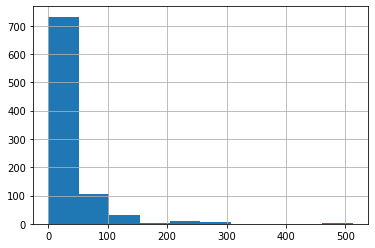

In [410]:
df['Fare'].hist();

我们这里采取了log处理，压缩fare的跨度，并且顾及了取值为0的情况。

In [411]:
df['LogFare'] = np.log(df['Fare']+1)

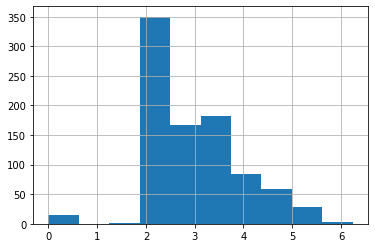

In [412]:
df['LogFare'].hist();

可以看到log后的fare分布更加均匀了也没有了long tail

同时从describe得到的表格中看出pclass只有三种取值,因此我们要考虑把它当成categorical feature

In [413]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

#### Object Feature

In [414]:
df.describe(include=object)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [415]:
# Pandas can create these automatically using get_dummies(), which also remove the original columns.
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [416]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


#### 将数据打包成tensor 

In [417]:
from torch import tensor

t_dep = tensor(df.Survived)
t_dep = t_dep.unsqueeze(1)
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
t_indep = tensor(df[indep_cols].values, dtype=torch.float)



# Setting up a linear model

注意这里我们不需要加intercept,也不需要在data上创造一个column全是1。因为我们有Sex_Male, Sex_Female这两个column，他们代替了intercept的作用.

In [418]:
torch.manual_seed(442)
n_coeff = t_indep.shape[1]
coeffs = torch.rand((n_coeff,1))-0.5
coeffs

tensor([[-0.4629],
        [ 0.1386],
        [ 0.2409],
        [-0.2262],
        [-0.2632],
        [-0.3147],
        [ 0.4876],
        [ 0.3136],
        [ 0.2799],
        [-0.4392],
        [ 0.2103],
        [ 0.3625]])

In [419]:
# 注意*是逐元素乘法 @是矩阵乘法
t_indep*coeffs.T


tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.2632,  -0.0000,   0.0000

这里我们发现第一列（对应"Age")的数值范围明显大于其他列，会dominating sum of row。为此，我们要规范所有feature的取值区间到[0,1]之间

In [420]:
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals

In [421]:
t_indep*coeffs.T

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [422]:
preds = t_indep@coeffs
preds[:10]

tensor([[ 0.1927],
        [-0.6239],
        [ 0.0979],
        [ 0.2056],
        [ 0.0968],
        [ 0.0066],
        [ 0.1306],
        [ 0.3476],
        [ 0.1613],
        [-0.6285]])

In [423]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5382)

In [424]:
def calc_preds(coeffs, indeps): return indeps@coeffs
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

自己写了个大概框架，接下来要用正式用validation set来很计算metrics

epoch:0 loss:0.5382388234138489
epoch:5 loss:0.4670090675354004
epoch:10 loss:0.4105382561683655
epoch:15 loss:0.35821670293807983
epoch:20 loss:0.32404229044914246
epoch:25 loss:0.3007414937019348
epoch:30 loss:0.2883740961551666
epoch:35 loss:0.27372071146965027
epoch:40 loss:0.26560190320014954
epoch:45 loss:0.26037028431892395


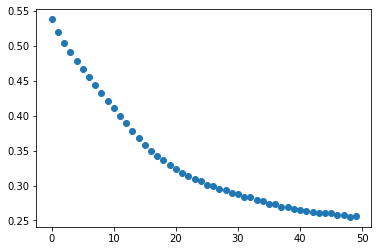

In [425]:
torch.manual_seed(442)
coeffs = torch.rand((n_coeff,1))-0.5
coeffs.requires_grad_()
record = []
lr = 0.1
for epoch in range(50):
  loss = calc_loss(coeffs,t_indep,t_dep)
  loss.backward()
  coeffs.data -= coeffs.grad*lr
  coeffs.grad.zero_()
  record.append([epoch,loss.item()])
  if epoch%5==0:
    print(f'epoch:{epoch} loss:{loss}')

record_df = pd.DataFrame(record,columns=['epoch','loss'])
import matplotlib.pyplot as plt
plt.scatter(x='epoch',y='loss',data=record_df)

# Training the linear model

In [426]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

In [427]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]


将功能模块函数化

In [433]:
def update_coeffs(coeffs, lr):
    coeffs.data -= coeffs.grad * lr
    coeffs.grad.zero_()

def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")
  
def init_coeffs(): return (torch.rand((n_coeff,1))-0.5).requires_grad_()


In [434]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

In [435]:
coeffs = train_model(50, lr=0.1)


0.536; 0.518; 0.503; 0.489; 0.477; 0.465; 0.454; 0.443; 0.431; 0.420; 0.410; 0.399; 0.388; 0.378; 0.368; 0.358; 0.350; 0.343; 0.337; 0.330; 0.325; 0.319; 0.315; 0.310; 0.309; 0.302; 0.301; 0.296; 0.295; 0.290; 0.291; 0.285; 0.284; 0.280; 0.280; 0.275; 0.276; 0.270; 0.271; 0.266; 0.269; 0.264; 0.267; 0.263; 0.264; 0.261; 0.262; 0.259; 0.258; 0.257; 

查看每个feature的coefficient

In [436]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor([-0.2391]),
 'SibSp': tensor([0.0568]),
 'Parch': tensor([0.2175]),
 'LogFare': tensor([0.0012]),
 'Sex_male': tensor([-0.4694]),
 'Sex_female': tensor([0.3018]),
 'Pclass_1': tensor([0.6391]),
 'Pclass_2': tensor([0.4451]),
 'Pclass_3': tensor([0.4072]),
 'Embarked_C': tensor([0.1547]),
 'Embarked_Q': tensor([0.2134]),
 'Embarked_S': tensor([0.1760])}

# Measuring accuracy

In [437]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)


tensor(0.7921)

# Using Sigmoid

In [438]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)


In [439]:
coeffs = train_model(lr=100)

0.510; 0.327; 0.294; 0.207; 0.201; 0.199; 0.198; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [440]:
acc(coeffs)

tensor(0.8258)

In [441]:
show_coeffs()

{'Age': tensor([-1.5061]),
 'SibSp': tensor([-1.1575]),
 'Parch': tensor([-0.4267]),
 'LogFare': tensor([0.2543]),
 'Sex_male': tensor([-10.3320]),
 'Sex_female': tensor([8.4185]),
 'Pclass_1': tensor([3.8389]),
 'Pclass_2': tensor([2.1398]),
 'Pclass_3': tensor([-6.2331]),
 'Embarked_C': tensor([1.4771]),
 'Embarked_Q': tensor([2.1168]),
 'Embarked_S': tensor([-4.7958])}

# Submitting to Kaggle

In [442]:
tst_df = pd.read_csv(path/'test.csv')

In [443]:
tst_df.fillna(modes,inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])
tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals

In [444]:
tst_df['Survived'] = (calc_preds(coeffs,tst_indep)>0.5).int()


In [445]:
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv(path/'sub.csv', index=False)

In [446]:
sub_df


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# A neural network

In [447]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.5
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

In [448]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.data -= layer.grad * lr
        layer.grad.zero_()

In [449]:
coeffs = train_model(lr=1.4)

0.542; 0.521; 0.492; 0.457; 0.415; 0.376; 0.347; 0.327; 0.312; 0.299; 0.288; 0.278; 0.270; 0.264; 0.258; 0.253; 0.248; 0.244; 0.240; 0.237; 0.234; 0.232; 0.230; 0.228; 0.226; 0.225; 0.223; 0.222; 0.221; 0.220; 

In [450]:
acc(coeffs)

tensor(0.8315)

可见在这个小数据里，NN表现并没有大幅度进步.  
**The key thing is that we now know exactly what a real neural net looks like!** :)


# Deep learning

In [452]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [453]:
def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    input = indeps
    for i,l in enumerate(layers):
      input = input@l + consts[i]  
      if i<len(layers)-1:
        input = F.relu(input)  
    return torch.sigmoid(input)

def update_coeffs(coeffs, lr):
  layers, consts = coeffs
  for l in layers+consts:
      l.data -= l.grad * lr
      l.grad.zero_()
      

In [454]:
coeffs = train_model(lr=4)

0.521; 0.483; 0.427; 0.379; 0.379; 0.379; 0.379; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.378; 0.377; 0.376; 0.371; 0.333; 0.239; 0.224; 0.208; 0.204; 0.203; 0.203; 0.207; 0.197; 0.196; 0.195; 

In [455]:
acc(coeffs)

tensor(0.8258)